In [ ]:
import os
import typing
from typing import Tuple

import numpy as np
import pandas as pd

# OpenCV and Scikit-Image for image manipulation
# This code prefers skimage for resize but you can also import and use cv2
from skimage.transform import resize
from skimage.measure import label, regionprops, perimeter
from skimage.morphology import binary_dilation, square

# Seaborn and Matplotlib for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-Learn and helper functions
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Data Preparation 
 • Wafer maps have different shapes. Resize all wafer maps to (64, 64).
  
 • Convert the failure type string to numerical value.

In [2]:
data = np.load("data/wafermap_train.npy", allow_pickle=True)

df = pd.DataFrame(
    list(data.tolist()),
    columns=["dieSize", "failureType", "lotName", "trainTestLabel", "waferIndex", "waferMap"]
)

# Create dictionary called 'string2int' for converting string to numeric number
string2int = {
    'Center': 0,
    'Edge-Loc': 1,
    'Scratch': 2,
    'Donut': 3,
    'Near-full': 4,
}

def convert_failure_type(failure_type: str) -> int:
    return string2int[failure_type]

def resize_wafer_map(wafer_map: np.ndarray, output_shape: tuple = (64, 64)) -> np.ndarray:
    return resize(wafer_map, output_shape, order=0, anti_aliasing=False, preserve_range=True)

# Implement a function that creates dataframe columns to store the return values of the two tasks below using convert_failure_type and resize_wafer_map:
#  (1) reshapes the wafer maps as a numpy array of shape (64, 64)
#  (2) converts the failureType into numeric values
def prepare_data(df: pd.DataFrame, has_labels: bool = True) -> pd.DataFrame:
    df = df.copy()
    # (1) waferMap -> waferMap_resized (64x64)
    df["waferMap_resized"] = df["waferMap"].apply(resize_wafer_map)
    # (2) failureType -> failureType_num
    if has_labels:
        df["failureType_num"] = df["failureType"].apply(convert_failure_type)
    return df

df_train = prepare_data(df, has_labels=True)

print("Columns Name: ", df_train.columns.tolist())
print("failureType:", df_train["failureType"].unique())
print("failureType_Num:", df_train["failureType_num"].unique())
print("A shape of waferMap_resized: ", df_train["waferMap_resized"].iloc[0].shape)


Columns Name:  ['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferIndex', 'waferMap', 'waferMap_resized', 'failureType_num']
failureType: ['Center' 'Edge-Loc' 'Scratch' 'Donut' 'Near-full']
failureType_Num: [0 1 2 3 4]
A shape of waferMap_resized:  (64, 64)


# 2. Feature Engineering

In [3]:
FAIL = 2 # failing die
PASS = 1 # passing die
NO_DIE = 0 # no die
RANDOM_SEED = 10

# Detects connected failing dies using skimage and selects "one with the largest area(=salient region)" for each wafer map
def get_salient_region(row: pd.Series) -> np.ndarray:
    wafer = row["waferMap_resized"]

    fail_mask = (wafer == FAIL).astype(np.uint8) # 0 = no-die, 1 = pass, 2 = fail
 
    labeled = label(fail_mask, connectivity=2)

    if labeled.max() == 0:
        return np.zeros_like(fail_mask, dtype=np.uint8)

    props = regionprops(labeled)
    largest = max(props, key=lambda r: r.area)

    salient_region = (labeled == largest.label).astype(np.uint8)
    return salient_region

# Returns the ratio of the area of the salient region to the area of the wafer map
def get_area_ratio(row: pd.Series) -> float:
    wafer = np.asarray(row["waferMap_resized"]).astype(int)
    salient = np.asarray(row["salientRegion"]).astype(int)

    wafer_area = np.sum(wafer != NO_DIE) 
    salient_area = np.sum(salient == 1)
    return float(salient_area / wafer_area) if wafer_area > 0 else 0.0

# Returns the ratio of the perimeter of the salient region to the radius of the wafer map
def get_perimeter_ratio(row: pd.Series) -> float:
    wafer = np.asarray(row["waferMap_resized"]).astype(int)
    salient = np.asarray(row["salientRegion"]).astype(np.uint8)

    sal_perimeter = perimeter(salient.astype(bool))
    wafer_area = np.count_nonzero(wafer != NO_DIE)  
    wafer_radius = np.sqrt(wafer_area / np.pi) if wafer_area > 0 else 0.0
    return float(sal_perimeter / wafer_radius) if wafer_radius > 0 else 0.0

# Returns the maximal distance between the salient region and the center of the wafer map
def get_max_dist_from_center(row: pd.Series) -> float:
    wafer = np.asarray(row["waferMap_resized"])
    H, W = wafer.shape[:2]
    cy, cx = (H - 1) / 2.0, (W - 1) / 2.0

    salient = np.asarray(row["salientRegion"]).astype(bool)
    ys, xs = np.nonzero(salient)
    if ys.size == 0:
        return 0.0
    dists = np.sqrt((ys - cy) ** 2 + (xs - cx) ** 2)
    return float(dists.max())

# Returns the minimal distance between the salient region and the center of the wafer map
def get_min_dist_from_center(row: pd.Series) -> float:
    wafer = np.asarray(row["waferMap_resized"])
    H, W = wafer.shape[:2]
    cy, cx = (H - 1) / 2.0, (W - 1) / 2.0

    salient = np.asarray(row["salientRegion"]).astype(bool)
    ys, xs = np.nonzero(salient)
    if ys.size == 0:
        return 0.0
    dists = np.sqrt((ys - cy) ** 2 + (xs - cx) ** 2)
    return float(dists.min())

# Returns the ratio of the length of the major axis of the estimated ellipse surrounding the salient region to the radius of the wafer map
def get_major_axis_ratio(row: pd.Series) -> float:
    salient = np.asarray(row["salientRegion"]).astype(np.uint8)
    labeled = label(salient)
    if labeled.max() == 0:
        return 0.0
    props = regionprops(labeled)
    largest = max(props, key=lambda r: r.area)
    major_axis_length = largest.major_axis_length

    wafer = np.asarray(row["waferMap_resized"])
    wafer_area = np.count_nonzero(wafer != NO_DIE)
    wafer_radius = np.sqrt(wafer_area / np.pi) if wafer_area > 0 else 0.0
    return float(major_axis_length / wafer_radius) if wafer_radius > 0 else 0.0

# Returns the ratio of the length of the minor axis of the estimated ellipse surrounding the salient region to the radius of the wafer map
def get_minor_axis_ratio(row: pd.Series) -> float:
    salient = np.asarray(row["salientRegion"]).astype(np.uint8)
    labeled = label(salient)
    if labeled.max() == 0:
        return 0.0
    props = regionprops(labeled)
    largest = max(props, key=lambda r: r.area)
    minor_axis_length = largest.minor_axis_length

    wafer = np.asarray(row["waferMap_resized"])
    wafer_area = np.count_nonzero(wafer != NO_DIE)
    wafer_radius = np.sqrt(wafer_area / np.pi) if wafer_area > 0 else 0.0
    return float(minor_axis_length / wafer_radius) if wafer_radius > 0 else 0.0

# Returns the solidity, indicating the proportion of defective dies in the estimated convex hull of the salient region
def get_solidity(row: pd.Series) -> float:
    salient = np.asarray(row["salientRegion"]).astype(np.uint8)
    if salient.sum() == 0:
        return 0.0

    labeled = label(salient, connectivity=2)
    props = regionprops(labeled)
    largest = max(props, key=lambda r: r.area)
    return float(largest.solidity)

def get_eccentricity(row: pd.Series) -> float:
    salient = np.asarray(row["salientRegion"]).astype(np.uint8)
    if salient.sum() == 0:
        return 0.0

    labeled = label(salient, connectivity=2)
    props = regionprops(labeled)
    largest = max(props, key=lambda r: r.area)
    return float(largest.eccentricity)

# Returns the ratio of the failed dies on the wafer map to the total number of dies on the wafer map
def get_yield_loss(row: pd.Series) -> float:
    wafer = np.asarray(row["waferMap_resized"]).astype(int)
    fail_count = np.sum(wafer == FAIL) # 0=no-die, 1=pass, 2=fail
    total_count = wafer.size 
    return float(fail_count / total_count) if total_count > 0 else 0.0

# A helper function that returns a numpy array highlighting the outermost two rings of the wafer map with nonzero value
def ring_label_from_outside(wafer_map: np.ndarray) -> np.ndarray:
    from scipy.ndimage import binary_erosion

    mask = (np.asarray(wafer_map) != NO_DIE).astype(np.uint8)

    se = np.ones((3, 3), dtype=np.uint8) # 8-connected erosion kernel

    eroded2 = binary_erosion(mask, structure=se, iterations=2, border_value=0)
    ring_labels = (mask & (~eroded2)).astype(np.uint8)

    return ring_labels

# Returns the ratio of the failed dies on the outermost two rings of the wafer map to the total number of dies on the outermost two rings of the wafer map
# Use ring_label_from_outside helper function
def get_edge_yield_loss(row: pd.Series) -> float:
    wafer = np.asarray(row["waferMap_resized"]).astype(int)
    rings = ring_label_from_outside(wafer)

    ring_dies = (wafer != 0) & (rings == 1)
    if ring_dies.sum() == 0:
        return 0.0

    fail_on_rings = (wafer == 2) & (rings == 1)
    return float(fail_on_rings.sum() / ring_dies.sum())



In [4]:
def create_feature_columns(df_in: pd.DataFrame) -> pd.DataFrame:
    df_out = df_in.copy()

    # salient region
    df_out["salientRegion"] = df_out.apply(get_salient_region, axis=1)

    df_out["areaRatio"]        = df_out.apply(get_area_ratio,        axis=1)
    df_out["perimeterRatio"]   = df_out.apply(get_perimeter_ratio,   axis=1)
    df_out["maxDistFromCenter"]= df_out.apply(get_max_dist_from_center, axis=1)
    df_out["minDistFromCenter"]= df_out.apply(get_min_dist_from_center, axis=1)
    df_out["majorAxisRatio"]   = df_out.apply(get_major_axis_ratio,  axis=1)
    df_out["minorAxisRatio"]   = df_out.apply(get_minor_axis_ratio,  axis=1)
    df_out["solidity"]         = df_out.apply(get_solidity,          axis=1)
    df_out["eccentricity"]     = df_out.apply(get_eccentricity,      axis=1)
    df_out["yieldLoss"]        = df_out.apply(get_yield_loss,        axis=1)
    df_out["edgeYieldLoss"]    = df_out.apply(get_edge_yield_loss,   axis=1)

    return df_out

In [5]:
df_feat = create_feature_columns(df_train)

# From the dataframe select the 10 features we want to use and extract them as X and extract the numerical failure type labels as y. 
# Then, split dataset into training and validation set. Use RANDOM_SEED for random_state
feature_cols = [
    "areaRatio", "perimeterRatio", "maxDistFromCenter",
    "minDistFromCenter", "majorAxisRatio", "minorAxisRatio",
    "solidity", "eccentricity", "yieldLoss", "edgeYieldLoss",
]

X = df_feat[feature_cols]
y = df_feat["failureType_num"]

# Extract features (X) and labels (y)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (2196, 10) (2196,)
Validation set shape: (550, 10) (550,)


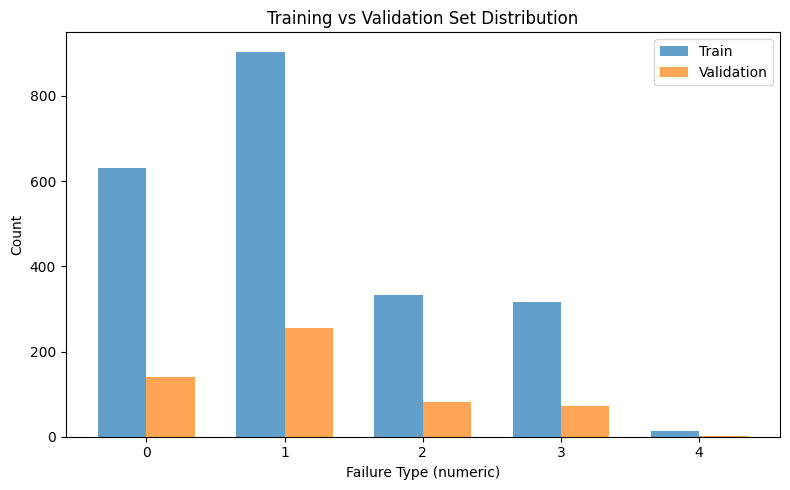

In [6]:
# check train/validation distribution
train_counts = y_train.value_counts().sort_index()
val_counts = y_val.value_counts().sort_index()

plt.figure(figsize=(8, 5))
bar_width = 0.35
x = range(len(train_counts))
plt.bar(x, train_counts, width=bar_width, label='Train', alpha=0.7)
plt.bar([i + bar_width for i in x], val_counts, width=bar_width, label='Validation', alpha=0.7)
plt.xticks([i + bar_width/2 for i in x], train_counts.index)
plt.xlabel('Failure Type (numeric)')
plt.ylabel('Count')
plt.title('Training vs Validation Set Distribution')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Model Training and Validation

In [7]:
# Defining an XGBoost model
xgb_model = XGBClassifier(
    n_estimators=800,  
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,    
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=5,
    eval_metric="mlogloss",    
    random_state=RANDOM_SEED,
    tree_method="hist",
)

In [9]:
# Train the model and apply early stopping on the validation set.
eval_set = [(X_train, y_train), (X_val, y_val)]

xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=True,
)

y_train_pred = xgb_model.predict(X_train)
y_val_pred   = xgb_model.predict(X_val)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc   = accuracy_score(y_val, y_val_pred)

print("\n===== Accuracy =====")
print(f"Train acc: {train_acc:.4f}")
print(f"Validation acc: {val_acc:.4f}")

print("\nValidation Classification Report (by numerical labels):")
print(classification_report(y_val, y_val_pred))

[0]	validation_0-mlogloss:1.42624	validation_1-mlogloss:1.42037
[1]	validation_0-mlogloss:1.34177	validation_1-mlogloss:1.33958
[2]	validation_0-mlogloss:1.26356	validation_1-mlogloss:1.26469
[3]	validation_0-mlogloss:1.19151	validation_1-mlogloss:1.19528
[4]	validation_0-mlogloss:1.12644	validation_1-mlogloss:1.13200
[5]	validation_0-mlogloss:1.06597	validation_1-mlogloss:1.07428
[6]	validation_0-mlogloss:1.01043	validation_1-mlogloss:1.02094
[7]	validation_0-mlogloss:0.95828	validation_1-mlogloss:0.97077
[8]	validation_0-mlogloss:0.91079	validation_1-mlogloss:0.92492
[9]	validation_0-mlogloss:0.86575	validation_1-mlogloss:0.88185
[10]	validation_0-mlogloss:0.82371	validation_1-mlogloss:0.84116
[11]	validation_0-mlogloss:0.78520	validation_1-mlogloss:0.80406
[12]	validation_0-mlogloss:0.74849	validation_1-mlogloss:0.76934
[13]	validation_0-mlogloss:0.71490	validation_1-mlogloss:0.73749
[14]	validation_0-mlogloss:0.68291	validation_1-mlogloss:0.70678
[15]	validation_0-mlogloss:0.65246	

# 4. Model Testing

In [14]:
test_data = np.load("data/wafermap_test.npy", allow_pickle=True)

df_test = pd.DataFrame(
    list(test_data.tolist()),
    columns=["dieSize", "lotName", "trainTestLabel", "waferIndex", "waferMap"]
)

df_test = prepare_data(df_test, has_labels=False)

df_test = create_feature_columns(df_test)

X_test = df_test[feature_cols]

y_test_pred = xgb_model.predict(X_test)

int2string = {v: k for k, v in string2int.items()}

df_test["failureType"] = [int2string[int(i)] for i in y_test_pred]

submission = df_test[["failureType"]]
submission.to_csv("scores.csv", index=False, encoding="utf-8")

print("✔ scores.csv saved")
submission.head()

✔ scores.csv saved


,failureType
0,Center
1,Center
2,Center
3,Center
4,Center
